In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, precision_recall_curve, auc, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
%config IPCompleter.greedy=True

In [2]:
data = pd.read_csv('bank_scoring_train.csv', delimiter='\t')
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs
y.value_counts()

0    89592
1     6624
Name: SeriousDlqin2yrs, dtype: int64

In [3]:
test = pd.read_csv('bank_scoring_test.csv', delimiter='\t')
X_test = test.drop('SeriousDlqin2yrs', axis=1)
y_test = test.SeriousDlqin2yrs
y_test.value_counts()

0    22407
1     1646
Name: SeriousDlqin2yrs, dtype: int64

In [4]:
f2score = make_scorer(fbeta_score, beta=2, average='binary')

# Дерево решений

In [5]:
clf = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 20),
              'min_samples_leaf': range(1, 100),
              'min_samples_split': range(2, 100)}
rand_search_cv_clf = RandomizedSearchCV(clf, parameters, n_iter=100, scoring=f2score, cv=5, n_jobs=-1)

In [6]:
rand_search_cv_clf.fit(X, y)
best_tree = rand_search_cv_clf.best_estimator_
rand_search_cv_clf.best_params_

{'min_samples_split': 17,
 'min_samples_leaf': 2,
 'max_depth': 18,
 'criterion': 'entropy'}

In [7]:
print('Train, f2score:', f2score(best_tree, X, y))
print('Test, f2score:', f2score(best_tree, X_test, y_test))

Train, f2score: 0.6005875137194138
Test, f2score: 0.42273673257023925


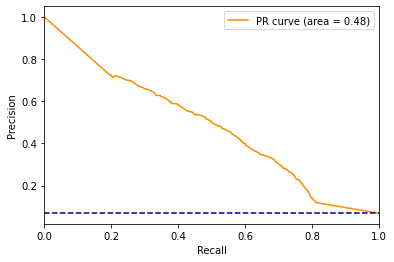

In [8]:
y_pred = best_tree.predict(X_test)
y_pred_proba = best_tree.predict_proba(X_test)

cf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf.ravel() 
P = tp + fn
N = fp + tn

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
pr_auc = auc(recall, precision)
# pr_auc = 0
plt.figure()
plt.plot(recall, precision, color='darkorange', 
         label='PR curve (area = %0.2f)' % pr_auc)
plt.plot([0, 1], [P / (P+N), P / (P+N)], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([P / (P+N) - 0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
_ = plt.legend(loc="best")

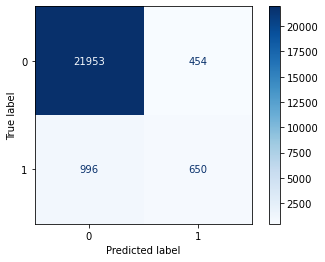

In [9]:
_ = plot_confusion_matrix(best_tree, X_test, y_test, display_labels=['0', '1'], cmap=plt.cm.Blues)

In [15]:
best_tree.score(X_test, y_test)

0.9397164594853032

# kNN

In [10]:
kNN = KNeighborsClassifier()
cv = 5
parameters = {'n_neighbors': range(1, 10), 
              'metric': ['euclidean', 'manhattan', 'chebyshev']}
grid_search_cv_kNN = GridSearchCV(kNN, parameters, scoring=f2score, cv=cv, n_jobs=-1)

In [11]:
grid_search_cv_kNN.fit(X, y)
best_kNN = grid_search_cv_kNN.best_estimator_
grid_search_cv_kNN.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

In [12]:
print('Train, f2score:', f2score(best_kNN, X, y))
print('Test, f2score:', f2score(best_kNN, X_test, y_test))

Train, f2score: 0.9998792416374834
Test, f2score: 0.6152491192752895


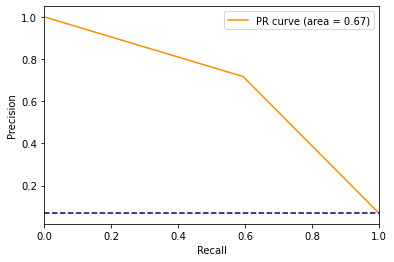

In [13]:
y_pred = best_kNN.predict(X_test)
y_pred_proba = best_kNN.predict_proba(X_test)

cf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf.ravel() 
P = tp + fn
N = fp + tn

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='darkorange', 
         label='PR curve (area = %0.2f)' % pr_auc)
plt.plot([0, 1], [P / (P+N), P / (P+N)], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([P / (P+N) - 0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
_ = plt.legend(loc="best")

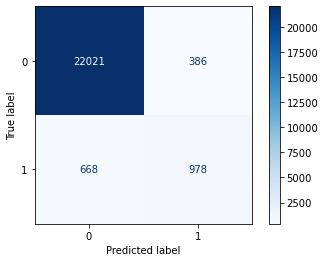

In [14]:
_ = plot_confusion_matrix(best_kNN, X_test, y_test, display_labels=['0', '1'], cmap=plt.cm.Blues, )

In [16]:
best_kNN.score(X_test, y_test)

0.9561801022741446